In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from itertools import permutations

# Set up matplotlib for better plots
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 10

In [2]:
def create_kuhn_poker_tree():
    """
    Create the complete Kuhn Poker game tree with chance nodes and player decisions.
    
    Cards: K=King (highest), Q=Queen, J=Jack (lowest)
    Actions: B=Bet, P=Pass/Check
    """
    G = nx.DiGraph()
    
    # Root chance node
    G.add_node("ROOT", type="chance", label="Chance\n(Deal Cards)")
    
    # All possible card deals (permutations of 2 cards from {J, Q, K})
    cards = ['J', 'Q', 'K']
    deals = list(permutations(cards, 2))  # All ways to deal 2 cards
    
    # Create nodes for each possible deal
    for deal in deals:
        p1_card, p2_card = deal
        deal_node = f"Deal_{p1_card}{p2_card}"
        prob = 1/6  # Each deal has equal probability
        
        G.add_node(deal_node, type="chance", label=f"P1:{p1_card}, P2:{p2_card}")
        G.add_edge("ROOT", deal_node, label=f"1/6", prob=prob)
        
        # Player 1's first decision
        p1_node = f"P1_{p1_card}{p2_card}"
        G.add_node(p1_node, type="player1", label=f"P1 to act\n(has {p1_card})")
        G.add_edge(deal_node, p1_node, label="")
        
        # Player 1 passes
        p1_pass_node = f"P1P_{p1_card}{p2_card}"
        G.add_node(p1_pass_node, type="player2", label=f"P2 to act\n(has {p2_card})\nP1 passed")
        G.add_edge(p1_node, p1_pass_node, label="Pass")
        
        # Player 1 bets
        p1_bet_node = f"P1B_{p1_card}{p2_card}"
        G.add_node(p1_bet_node, type="player2", label=f"P2 to act\n(has {p2_card})\nP1 bet")
        G.add_edge(p1_node, p1_bet_node, label="Bet")
        
        # From P1 Pass, P2 can pass or bet
        # P1 Pass, P2 Pass - Showdown
        pp_node = f"PP_{p1_card}{p2_card}"
        winner = p1_card if p1_card > p2_card else p2_card
        payoff = 1 if p1_card > p2_card else -1
        G.add_node(pp_node, type="terminal", label=f"Showdown\nWinner: P{'1' if p1_card > p2_card else '2'}\nPayoff: {payoff}")
        G.add_edge(p1_pass_node, pp_node, label="Pass")
        
        # P1 Pass, P2 Bet - P1 must decide again
        pb_node = f"PB_{p1_card}{p2_card}"
        G.add_node(pb_node, type="player1", label=f"P1 to act\n(has {p1_card})\nP2 bet")
        G.add_edge(p1_pass_node, pb_node, label="Bet")
        
        # From P1 Pass, P2 Bet, P1 can fold or call
        # P1 folds
        pbf_node = f"PBF_{p1_card}{p2_card}"
        G.add_node(pbf_node, type="terminal", label="P1 folds\nP2 wins\nPayoff: -1")
        G.add_edge(pb_node, pbf_node, label="Fold")
        
        # P1 calls
        pbc_node = f"PBC_{p1_card}{p2_card}"
        payoff = 2 if p1_card > p2_card else -2
        G.add_node(pbc_node, type="terminal", label=f"Showdown\nWinner: P{'1' if p1_card > p2_card else '2'}\nPayoff: {payoff}")
        G.add_edge(pb_node, pbc_node, label="Call")
        
        # From P1 Bet, P2 can fold or call
        # P2 folds
        bf_node = f"BF_{p1_card}{p2_card}"
        G.add_node(bf_node, type="terminal", label="P2 folds\nP1 wins\nPayoff: +1")
        G.add_edge(p1_bet_node, bf_node, label="Fold")
        
        # P2 calls
        bc_node = f"BC_{p1_card}{p2_card}"
        payoff = 2 if p1_card > p2_card else -2
        G.add_node(bc_node, type="terminal", label=f"Showdown\nWinner: P{'1' if p1_card > p2_card else '2'}\nPayoff: {payoff}")
        G.add_edge(p1_bet_node, bc_node, label="Call")
    
    return G

In [3]:
def plot_kuhn_poker_tree(G, title="Kuhn Poker Game Tree"):
    """
    Plot the Kuhn Poker game tree with proper layout and colors.
    """
    plt.figure(figsize=(20, 12))
    
    # Create a hierarchical layout
    pos = nx.nx_agraph.graphviz_layout(G, prog='dot') if hasattr(nx, 'nx_agraph') else None
    
    if pos is None:
        # Fallback to manual positioning if graphviz is not available
        pos = {}
        levels = {}
        
        # Manually assign levels based on node types and structure
        for node in G.nodes():
            if node == "ROOT":
                levels[node] = 0
            elif "Deal_" in node:
                levels[node] = 1
            elif node.startswith("P1_") and len(node.split("_")[1]) == 2:
                levels[node] = 2
            elif node.startswith("P1P_") or node.startswith("P1B_"):
                levels[node] = 3
            elif node.startswith("PB_"):
                levels[node] = 4
            else:  # Terminal nodes
                levels[node] = 5
        
        # Position nodes in levels
        for level in set(levels.values()):
            nodes_at_level = [n for n, l in levels.items() if l == level]
            for i, node in enumerate(nodes_at_level):
                pos[node] = (i - len(nodes_at_level)/2, -level)
    
    # Define colors for different node types
    node_colors = []
    node_sizes = []
    for node in G.nodes():
        node_type = G.nodes[node].get('type', 'unknown')
        if node_type == 'chance':
            node_colors.append('yellow')
            node_sizes.append(800)
        elif node_type == 'player1':
            node_colors.append('lightblue')
            node_sizes.append(1000)
        elif node_type == 'player2':
            node_colors.append('lightcoral')
            node_sizes.append(1000)
        elif node_type == 'terminal':
            node_colors.append('lightgreen')
            node_sizes.append(600)
        else:
            node_colors.append('gray')
            node_sizes.append(500)
    
    # Draw the graph
    nx.draw(G, pos, 
            node_color=node_colors,
            node_size=node_sizes,
            with_labels=False,
            arrows=True,
            edge_color='gray',
            arrowsize=20,
            arrowstyle='->')
    
    # Add custom labels
    labels = {}
    for node in G.nodes():
        labels[node] = G.nodes[node].get('label', node)
    
    nx.draw_networkx_labels(G, pos, labels, font_size=8, font_weight='bold')
    
    # Add edge labels
    edge_labels = {}
    for edge in G.edges():
        edge_labels[edge] = G.edges[edge].get('label', '')
    
    nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=7, font_color='red')
    
    # Add legend
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='yellow', markersize=10, label='Chance Node'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightblue', markersize=10, label='Player 1 Decision'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightcoral', markersize=10, label='Player 2 Decision'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightgreen', markersize=10, label='Terminal Node')
    ]
    plt.legend(handles=legend_elements, loc='upper right')
    
    plt.title(title, fontsize=16, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    # Print some statistics
    print(f"Game Tree Statistics:")
    print(f"- Total nodes: {len(G.nodes())}")
    print(f"- Total edges: {len(G.edges())}")
    print(f"- Maximum depth: {max(nx.shortest_path_length(G, 'ROOT').values())}")
    
    # Count node types
    node_types = {}
    for node in G.nodes():
        node_type = G.nodes[node].get('type', 'unknown')
        node_types[node_type] = node_types.get(node_type, 0) + 1
    
    for node_type, count in node_types.items():
        print(f"- {node_type.capitalize()} nodes: {count}")

/tmp/ipykernel_2270/1622413462.py:92: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


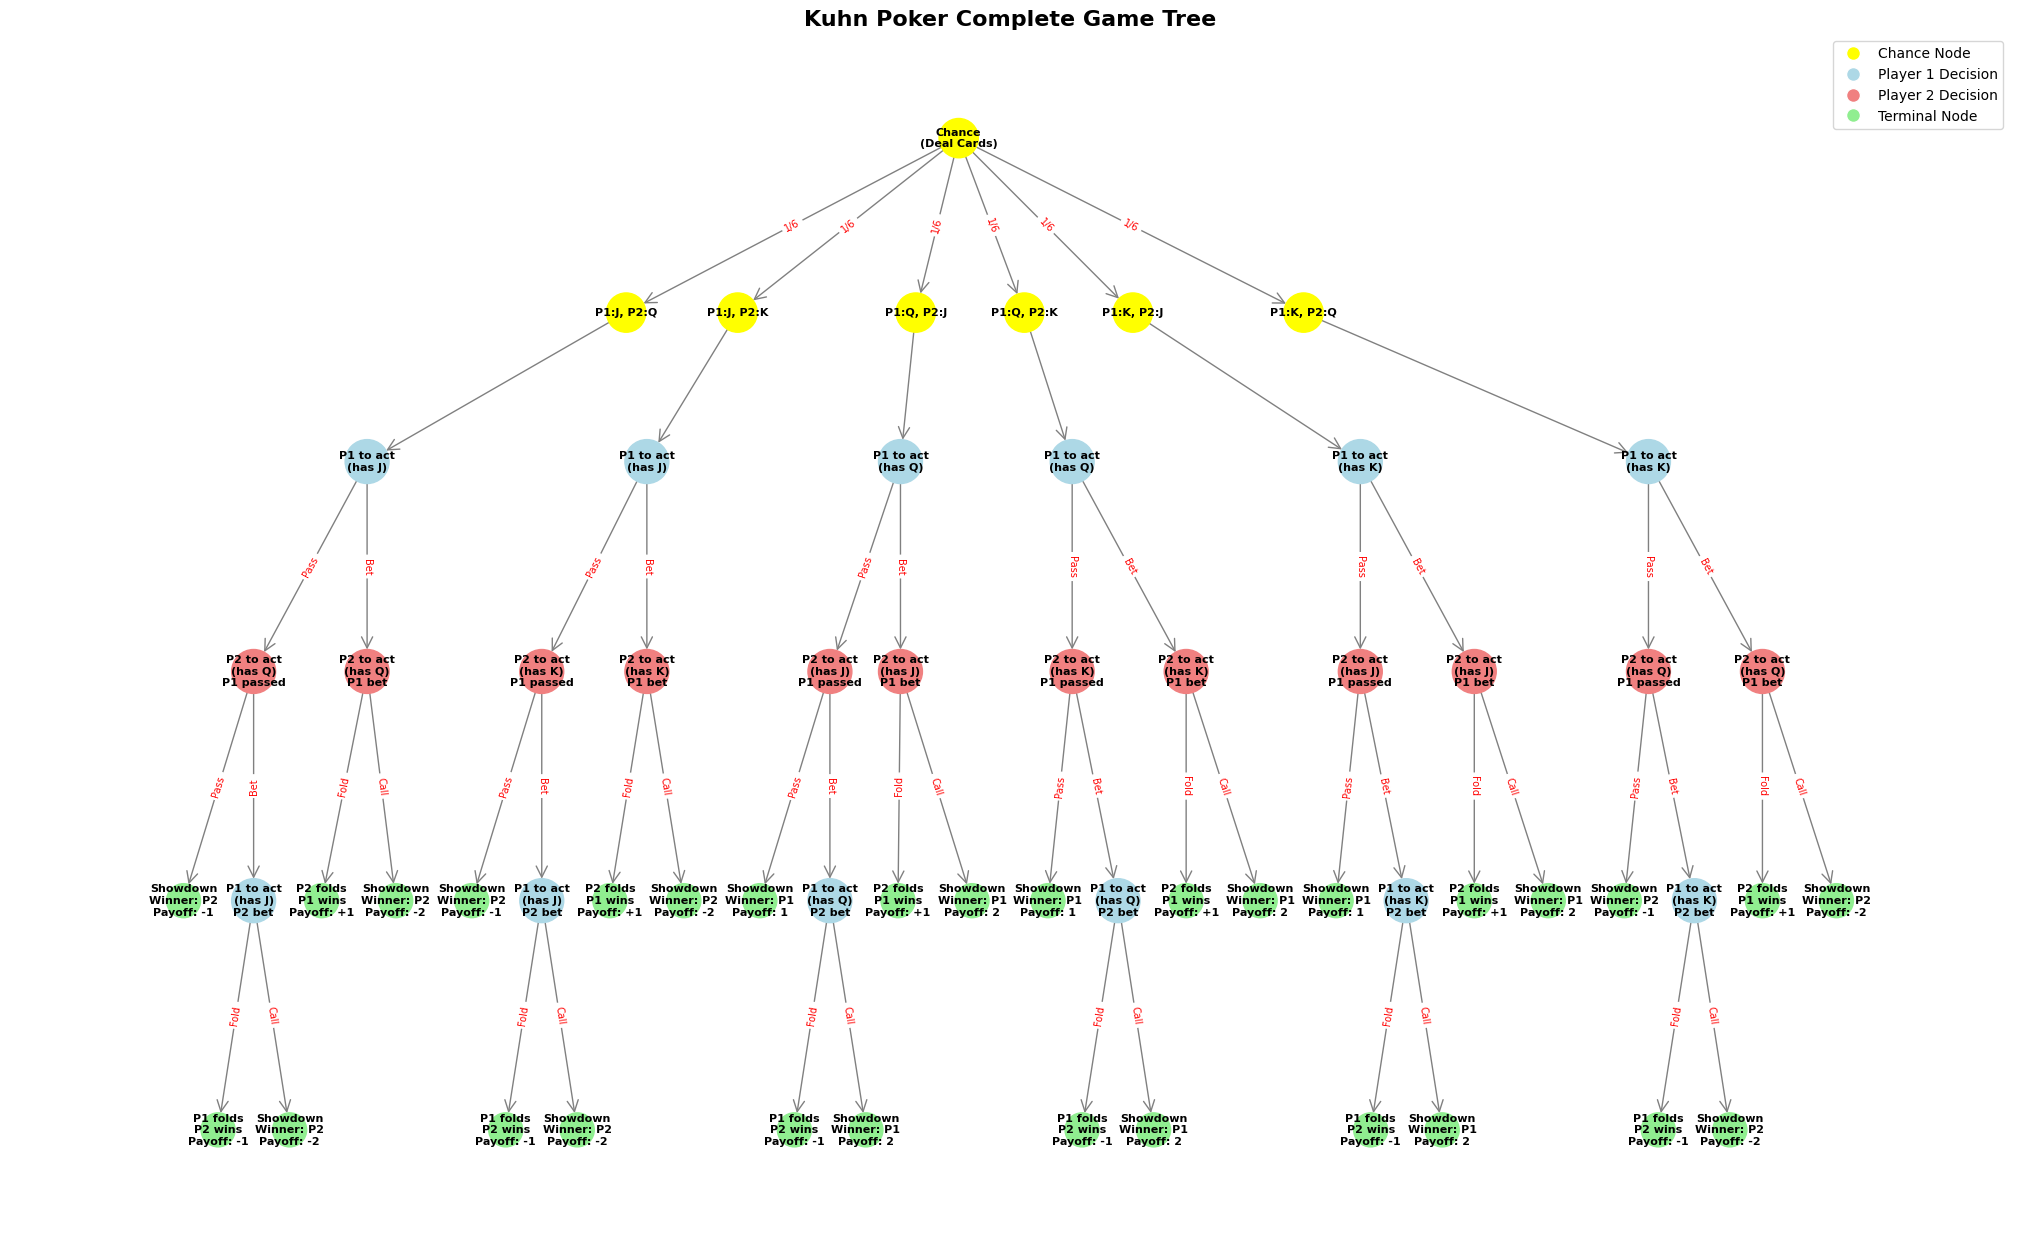

Game Tree Statistics:
- Total nodes: 61
- Total edges: 60
- Maximum depth: 5
- Chance nodes: 7
- Player1 nodes: 12
- Player2 nodes: 12
- Terminal nodes: 30


In [4]:
# Create and plot the Kuhn Poker game tree
kuhn_tree = create_kuhn_poker_tree()
plot_kuhn_poker_tree(kuhn_tree, "Kuhn Poker Complete Game Tree")

/tmp/ipykernel_2270/1622413462.py:92: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


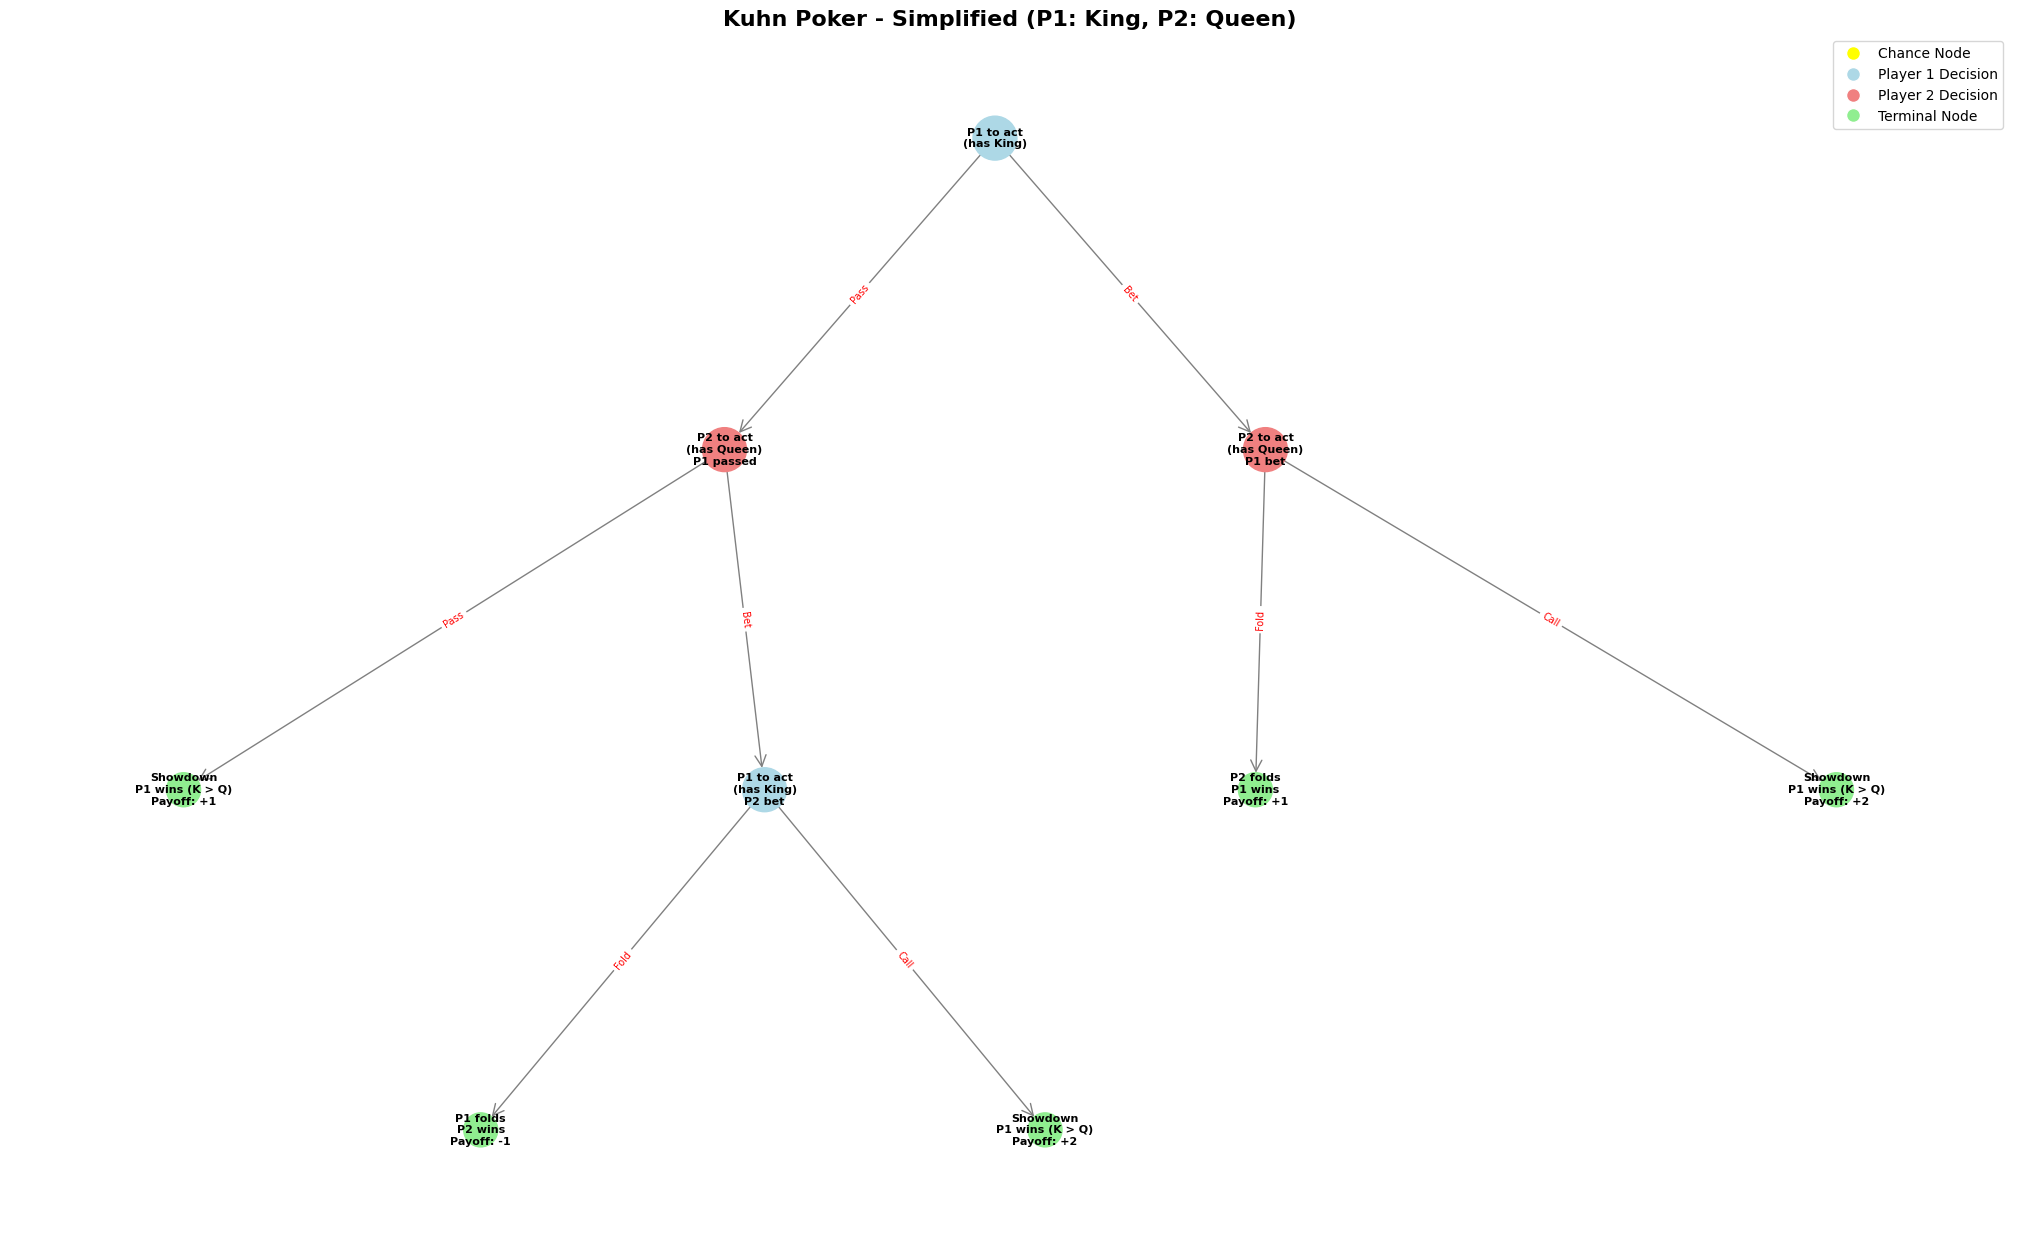

Game Tree Statistics:
- Total nodes: 9
- Total edges: 8


NodeNotFound: Source ROOT is not in G

In [5]:
def create_simplified_kuhn_tree():
    """
    Create a simplified Kuhn Poker tree showing just one card deal (e.g., P1: King, P2: Queen)
    for better readability and understanding of the game structure.
    """
    G = nx.DiGraph()
    
    # Start after the chance node - P1 has King, P2 has Queen
    G.add_node("P1_KQ", type="player1", label="P1 to act\n(has King)")
    
    # Player 1 passes
    G.add_node("P1P_KQ", type="player2", label="P2 to act\n(has Queen)\nP1 passed")
    G.add_edge("P1_KQ", "P1P_KQ", label="Pass")
    
    # Player 1 bets
    G.add_node("P1B_KQ", type="player2", label="P2 to act\n(has Queen)\nP1 bet")
    G.add_edge("P1_KQ", "P1B_KQ", label="Bet")
    
    # From P1 Pass, P2 Pass - Showdown (P1 wins with King)
    G.add_node("PP_KQ", type="terminal", label="Showdown\nP1 wins (K > Q)\nPayoff: +1")
    G.add_edge("P1P_KQ", "PP_KQ", label="Pass")
    
    # From P1 Pass, P2 Bet - P1 decides again
    G.add_node("PB_KQ", type="player1", label="P1 to act\n(has King)\nP2 bet")
    G.add_edge("P1P_KQ", "PB_KQ", label="Bet")
    
    # P1 folds (unlikely with King but possible)
    G.add_node("PBF_KQ", type="terminal", label="P1 folds\nP2 wins\nPayoff: -1")
    G.add_edge("PB_KQ", "PBF_KQ", label="Fold")
    
    # P1 calls
    G.add_node("PBC_KQ", type="terminal", label="Showdown\nP1 wins (K > Q)\nPayoff: +2")
    G.add_edge("PB_KQ", "PBC_KQ", label="Call")
    
    # From P1 Bet, P2 folds
    G.add_node("BF_KQ", type="terminal", label="P2 folds\nP1 wins\nPayoff: +1")
    G.add_edge("P1B_KQ", "BF_KQ", label="Fold")
    
    # From P1 Bet, P2 calls
    G.add_node("BC_KQ", type="terminal", label="Showdown\nP1 wins (K > Q)\nPayoff: +2")
    G.add_edge("P1B_KQ", "BC_KQ", label="Call")
    
    return G

# Plot the simplified version
simplified_tree = create_simplified_kuhn_tree()
plot_kuhn_poker_tree(simplified_tree, "Kuhn Poker - Simplified (P1: King, P2: Queen)")

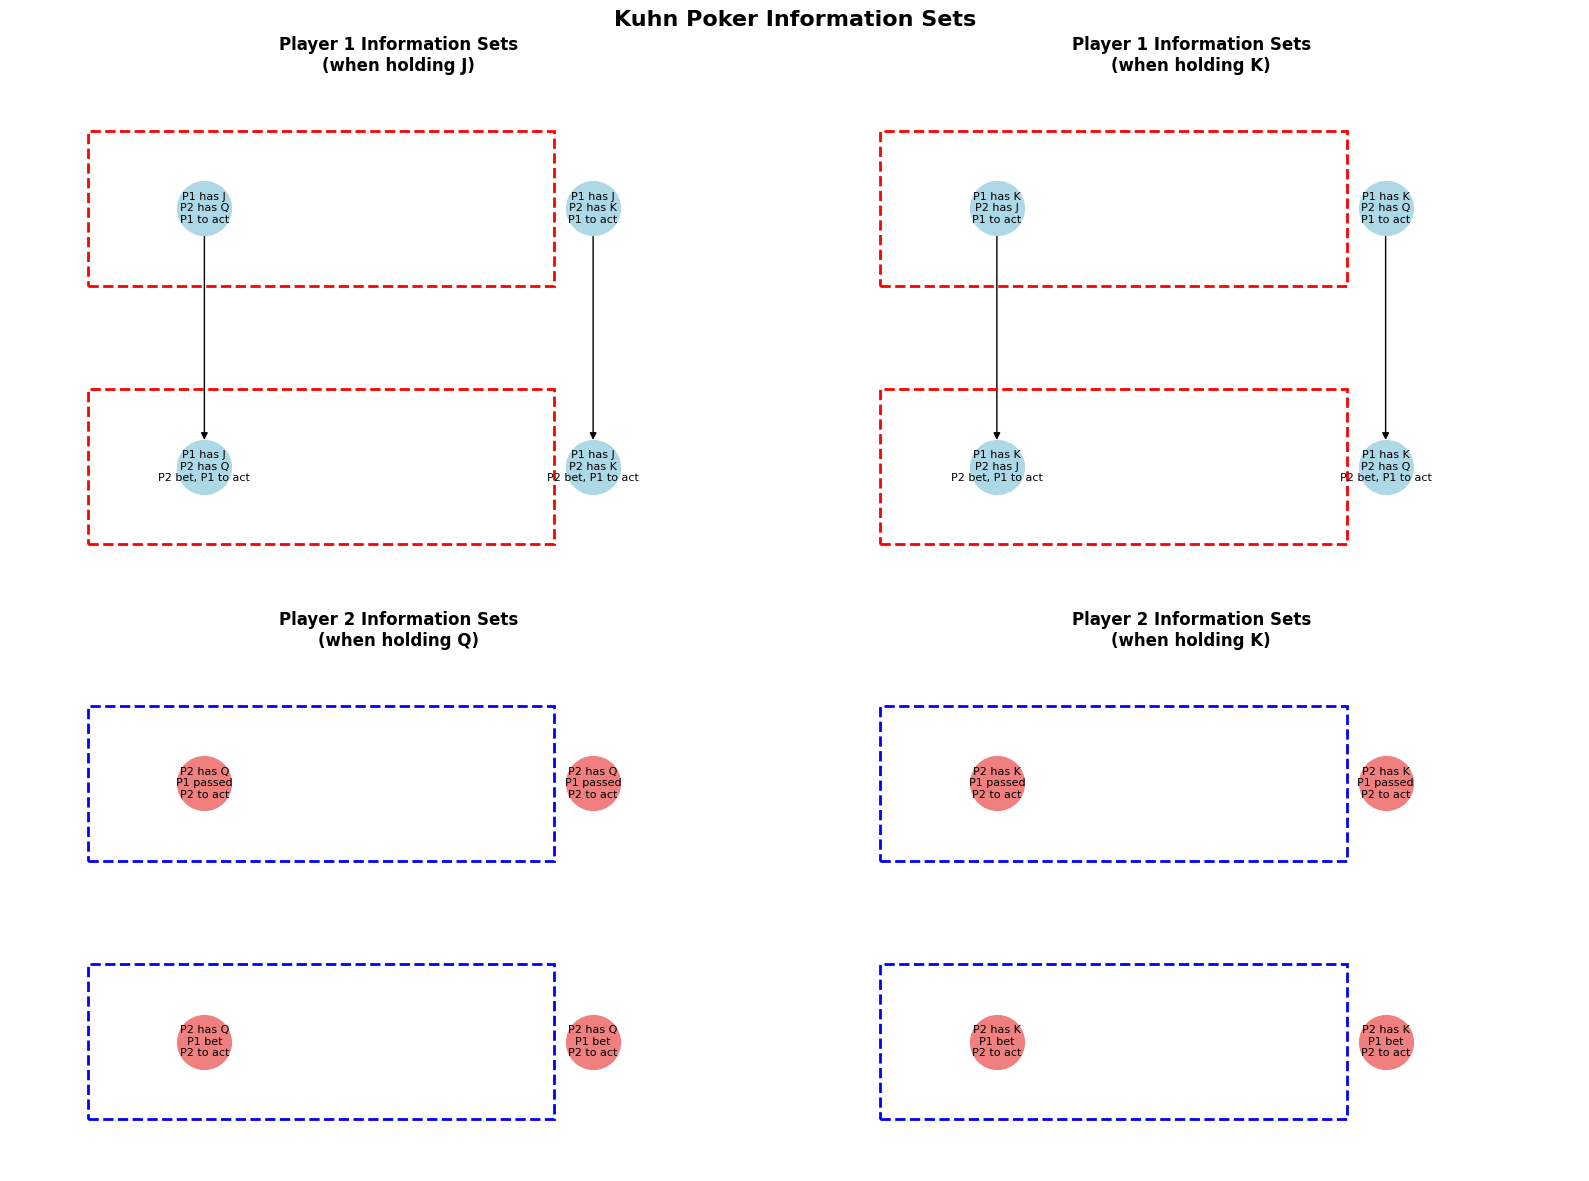

Information Sets Explanation:
- Dashed boxes group nodes that belong to the same information set
- Players cannot distinguish between nodes in the same information set
- This represents the imperfect information aspect of the game


In [6]:
def create_information_sets_diagram():
    """
    Create a diagram showing the information sets in Kuhn Poker.
    Information sets group nodes where a player cannot distinguish between game states.
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Kuhn Poker Information Sets', fontsize=16, fontweight='bold')
    
    # Player 1's information sets when they have different cards
    cards = ['J', 'Q', 'K']
    opponents = {'J': ['Q', 'K'], 'Q': ['J', 'K'], 'K': ['J', 'Q']}
    
    for i, card in enumerate(['J', 'K']):  # Show Jack and King as examples
        ax = axes[0, i]
        G = nx.DiGraph()
        
        # Create nodes for this card against both possible opponent cards
        for opp_card in opponents[card]:
            # Initial decision node
            init_node = f"P1_{card}{opp_card}_init"
            G.add_node(init_node, label=f"P1 has {card}\nP2 has {opp_card}\nP1 to act")
            
            # After P1 pass, P2 bet, P1 to act again
            second_node = f"P1_{card}{opp_card}_second"
            G.add_node(second_node, label=f"P1 has {card}\nP2 has {opp_card}\nP2 bet, P1 to act")
            
            G.add_edge(init_node, second_node, label="Pass → P2 Bet")
        
        # Position nodes
        pos = {}
        init_nodes = [n for n in G.nodes() if 'init' in n]
        second_nodes = [n for n in G.nodes() if 'second' in n]
        
        for j, node in enumerate(init_nodes):
            pos[node] = (j, 1)
        for j, node in enumerate(second_nodes):
            pos[node] = (j, 0)
        
        # Draw with dashed boxes around information sets
        nx.draw(G, pos, ax=ax, with_labels=False, node_color='lightblue', 
                node_size=1500, arrows=True)
        
        # Add labels
        labels = {n: G.nodes[n]['label'] for n in G.nodes()}
        nx.draw_networkx_labels(G, pos, labels, ax=ax, font_size=8)
        
        # Draw information set boundaries (dashed rectangles)
        # Initial decision information set
        ax.add_patch(plt.Rectangle((-0.3, 0.7), len(init_nodes)*0.6, 0.6, 
                                  fill=False, linestyle='--', linewidth=2, color='red'))
        
        # Second decision information set  
        ax.add_patch(plt.Rectangle((-0.3, -0.3), len(second_nodes)*0.6, 0.6, 
                                  fill=False, linestyle='--', linewidth=2, color='red'))
        
        ax.set_title(f'Player 1 Information Sets\n(when holding {card})', fontweight='bold')
        ax.set_xlim(-0.5, len(init_nodes)-0.5)
        ax.set_ylim(-0.5, 1.5)
        ax.axis('off')
    
    # Player 2's information sets
    for i, card in enumerate(['Q', 'K']):  # Show Queen and King as examples
        ax = axes[1, i]
        G = nx.DiGraph()
        
        # Create nodes for this card against both possible opponent cards
        for opp_card in opponents[card]:
            # After P1 pass
            pass_node = f"P2_{card}{opp_card}_afterpass"
            G.add_node(pass_node, label=f"P2 has {card}\nP1 passed\nP2 to act")
            
            # After P1 bet
            bet_node = f"P2_{card}{opp_card}_afterbet"
            G.add_node(bet_node, label=f"P2 has {card}\nP1 bet\nP2 to act")
        
        # Position nodes
        pos = {}
        pass_nodes = [n for n in G.nodes() if 'afterpass' in n]
        bet_nodes = [n for n in G.nodes() if 'afterbet' in n]
        
        for j, node in enumerate(pass_nodes):
            pos[node] = (j, 1)
        for j, node in enumerate(bet_nodes):
            pos[node] = (j, 0)
        
        # Draw
        nx.draw(G, pos, ax=ax, with_labels=False, node_color='lightcoral', 
                node_size=1500)
        
        # Add labels
        labels = {n: G.nodes[n]['label'] for n in G.nodes()}
        nx.draw_networkx_labels(G, pos, labels, ax=ax, font_size=8)
        
        # Draw information set boundaries
        ax.add_patch(plt.Rectangle((-0.3, 0.7), len(pass_nodes)*0.6, 0.6, 
                                  fill=False, linestyle='--', linewidth=2, color='blue'))
        ax.add_patch(plt.Rectangle((-0.3, -0.3), len(bet_nodes)*0.6, 0.6, 
                                  fill=False, linestyle='--', linewidth=2, color='blue'))
        
        ax.set_title(f'Player 2 Information Sets\n(when holding {card})', fontweight='bold')
        ax.set_xlim(-0.5, max(len(pass_nodes), len(bet_nodes))-0.5)
        ax.set_ylim(-0.5, 1.5)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print("Information Sets Explanation:")
    print("- Dashed boxes group nodes that belong to the same information set")
    print("- Players cannot distinguish between nodes in the same information set")
    print("- This represents the imperfect information aspect of the game")

# Create the information sets diagram
create_information_sets_diagram()

# Kuhn Poker Game Tree Analysis

## Game Description
Kuhn Poker is a simplified poker variant that serves as an excellent example for understanding game theory concepts:

- **Players**: 2 players
- **Cards**: 3 cards (Jack, Queen, King) 
- **Setup**: Each player receives 1 card, antes 1 chip
- **Actions**: Bet (add 1 chip) or Pass/Check
- **Payoffs**: Winner takes the pot, amounts vary by betting sequence

## Key Features

### 1. Imperfect Information
- Players cannot see opponent's card
- Creates uncertainty and strategic depth
- Information sets group indistinguishable game states

### 2. Game Tree Structure
- **Maximum depth**: 4 levels (including chance node)
- **Branching factor**: 2 (Bet or Pass at each decision)
- **Terminal payoffs**: {+1, +2, -1, -2} from Player 1's perspective

### 3. Strategic Considerations
- **Bluffing**: Betting with weak hands to make opponents fold
- **Value betting**: Betting with strong hands for value
- **Pot odds**: Mathematical relationship between bet size and pot size

## Applications
This simple game structure makes Kuhn Poker ideal for:
- Teaching game theory concepts
- Testing algorithmic approaches (CFR, fictitious play)
- Understanding Nash equilibria in extensive-form games